In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [18]:
models = {
#     "GloVe": "baseline",
#     "ConvS2S": "fairseq.wmt14.en-fr.fconv",
#     "InferSent": "infersent.allnli",
#     "IMDB": "imdbsentiment",
#     "skipthought": "skipthought",
#     "DisSent": "dissent.books8.epoch9",
#     "order": "order-embeddings",
#     "ELMo": "elmo.2x4096",
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-MRPC",
#     "BERT-CoLA": "bert.base.finetune-CoLA",
#     "BERT-MNLI": "bert.base.finetune-MNLI",
#     "BERT-RTE": "bert.base.finetune-RTE",
#     "BERT-SST": "bert.base.finetune-SST",
#     "BERT-WNLI": "bert.base.finetune-WNLI",
#     "BERT-QQP": "bert.base.finetune-QQP",
#     "BERT-SNLI": "bert.base.finetune-SNLI",
#     "openai": "transformer.roc",
    
    "BERT": "bert.base",
#     "BERT Large": "bert.base-large",
    "BERT-MRPC": "bert.base.finetune-5000-MRPC",
    "BERT-CoLA": "bert.base.finetune-5000-CoLA",
    "BERT-MNLI": "bert.base.finetune-5000-MNLI",
    "BERT-RTE": "bert.base.finetune-5000-RTE",
    "BERT-SST": "bert.base.finetune-5000-SST",
    "BERT-WNLI": "bert.base.finetune-5000-WNLI",
    "BERT-QQP": "bert.base.finetune-5000-QQP",
    "BERT-SNLI": "bert.base.finetune-5000-SNLI",
    
    "BERT-MNLIb": "bert.base.finetune-5000-MNLI.concat_with_base",
    "BERT-QQPb": "bert.base.finetune-5000-QQP.concat_with_base",
    "BERT-RTEb": "bert.base.finetune-5000-RTE.concat_with_base",
    "BERT-SNLIb": "bert.base.finetune-5000-SNLI.concat_with_base",
}

In [19]:
def analyze_encoding(name, results_path):
    df = pd.read_csv(results_path, index_col=[0, 1])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(x="subject", y="value", hue="type", data=df.reset_index().melt(id_vars=["subject", "type"], value_vars=["mar_fold_%i" % i for i in range(18)]), ax=ax)
    plt.ylim((40, 260))
    plt.ylabel("average rank")
    plt.title("%s: Within-subject MAR" % name)
    
    subj_perf = df.groupby("type").apply(lambda sub_df: sub_df.reset_index(level=0, drop=True).mean(axis=1)).T
    subj_perf.plot.bar(title="%s: Within-subject MAR" % name)
    
    return subj_perf

In [20]:
stats = {}

--------

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


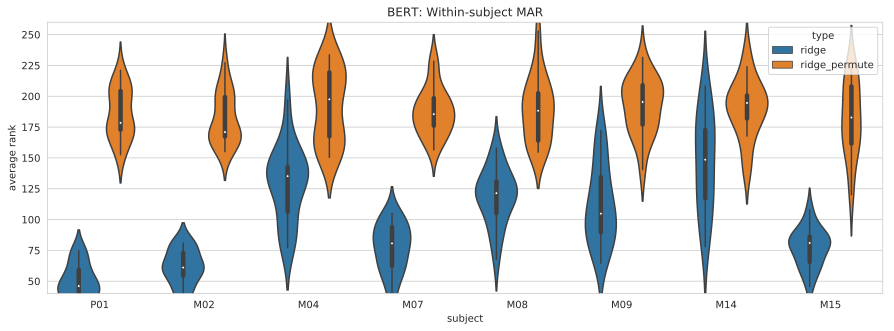

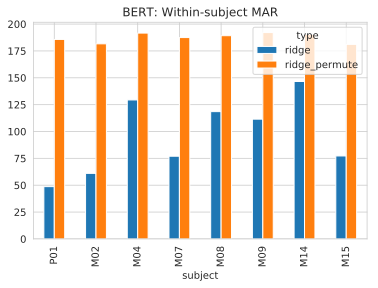

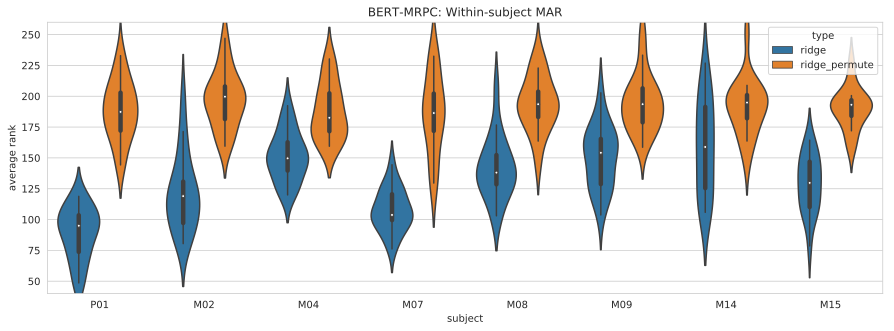

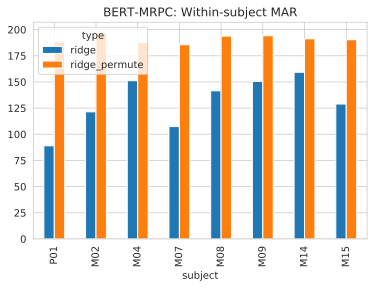

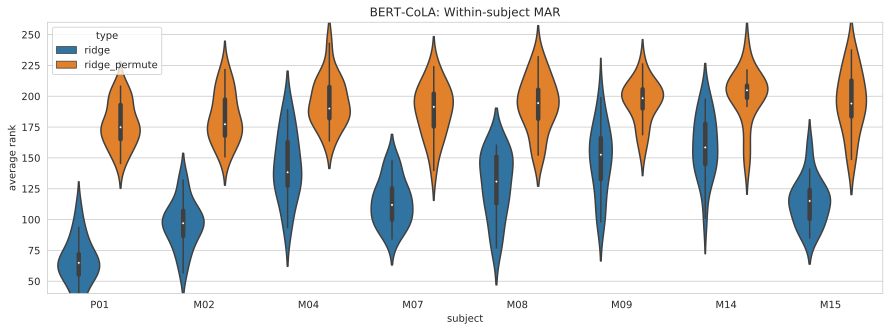

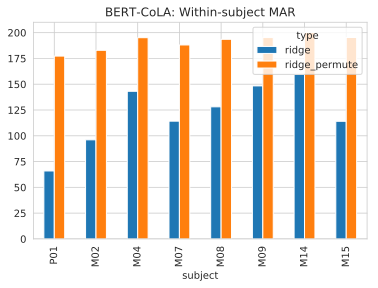

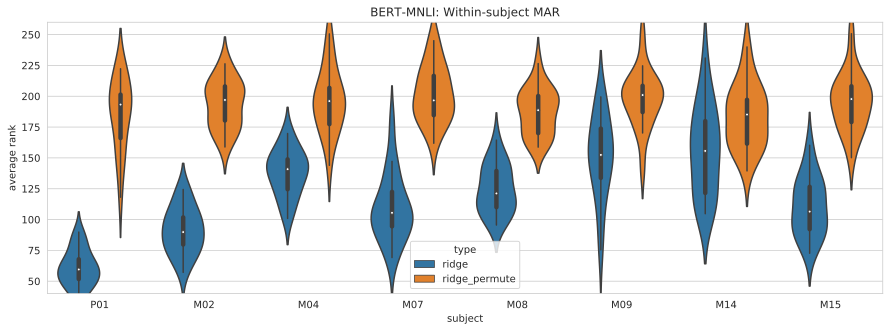

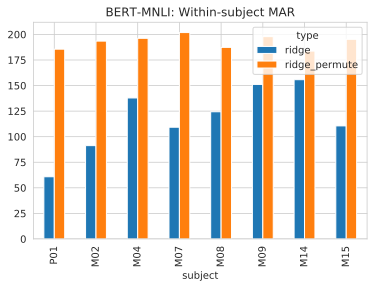

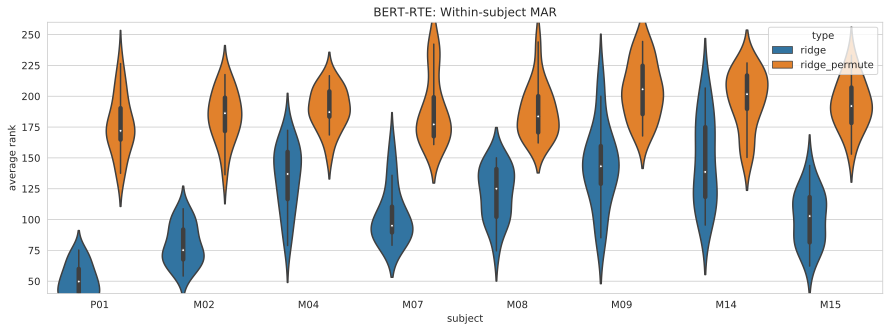

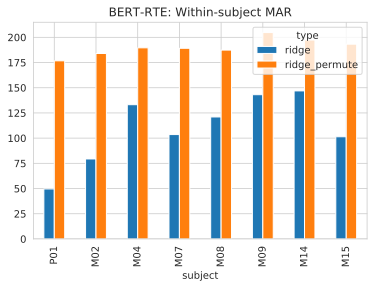

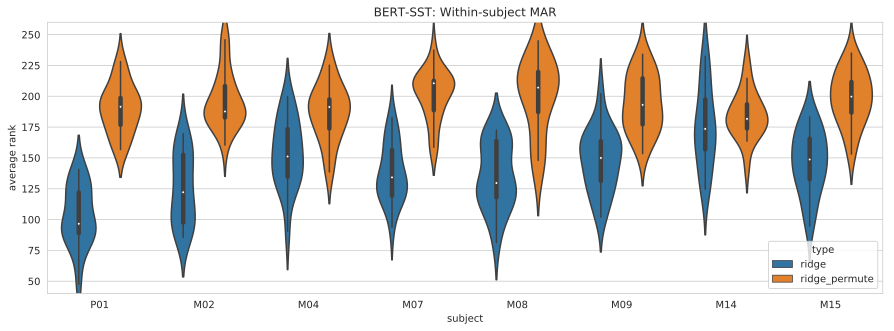

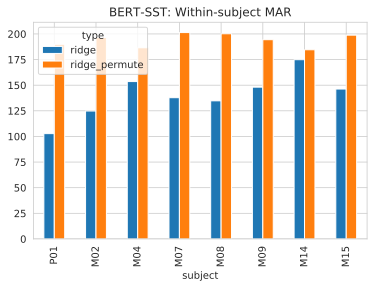

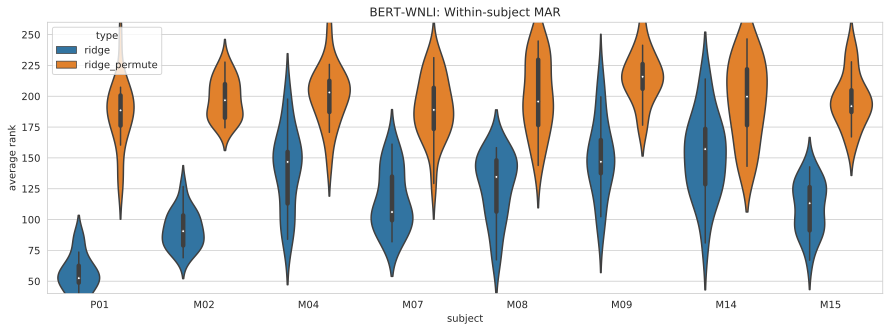

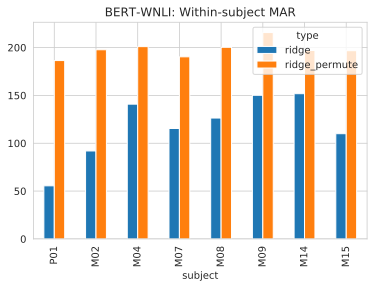

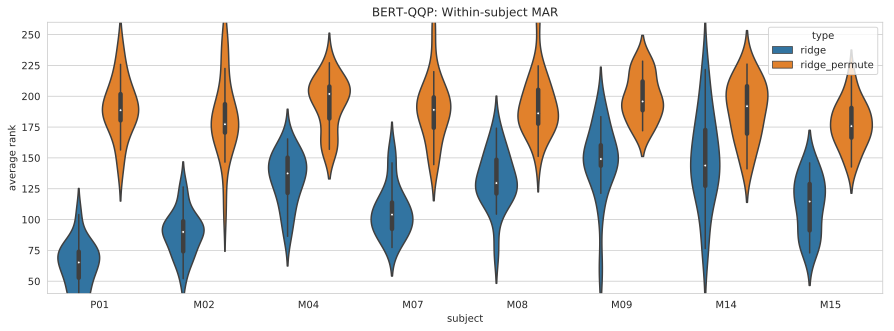

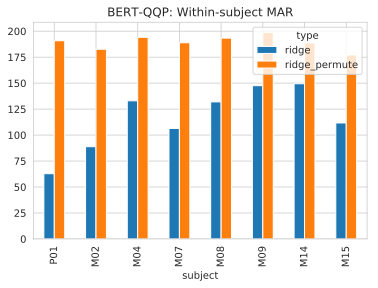

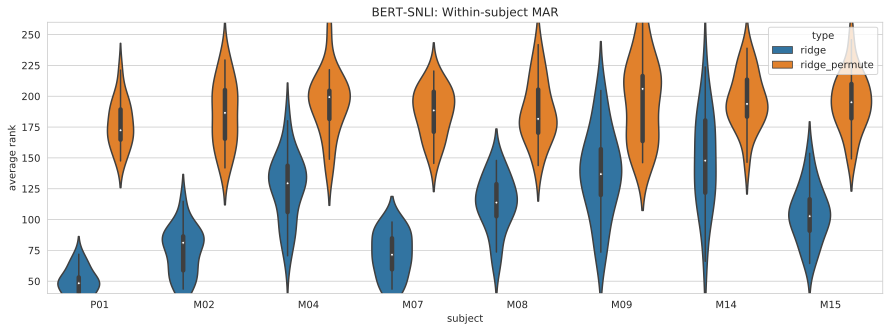

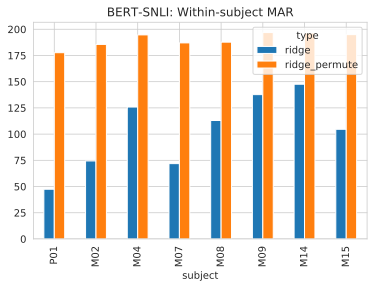

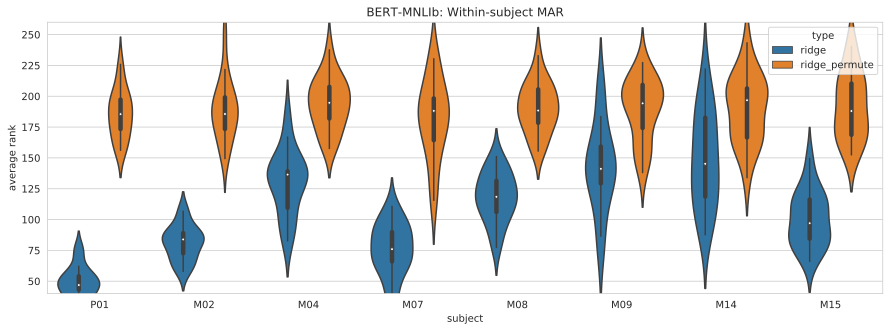

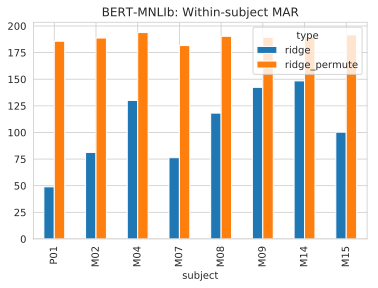

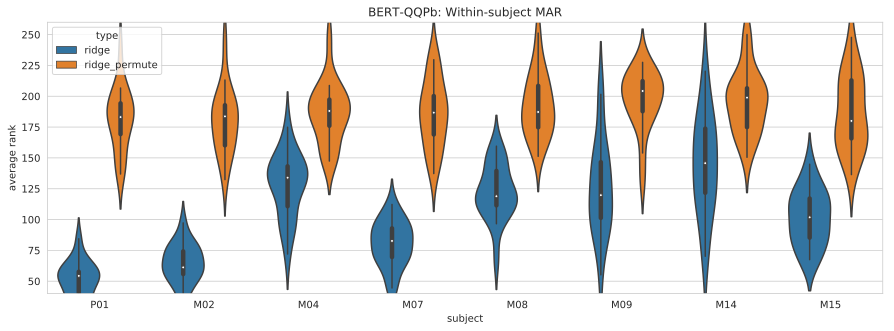

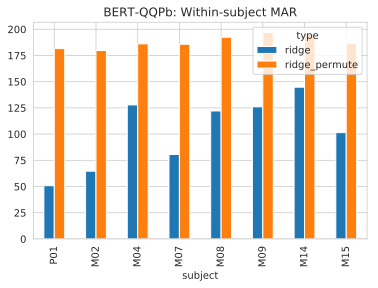

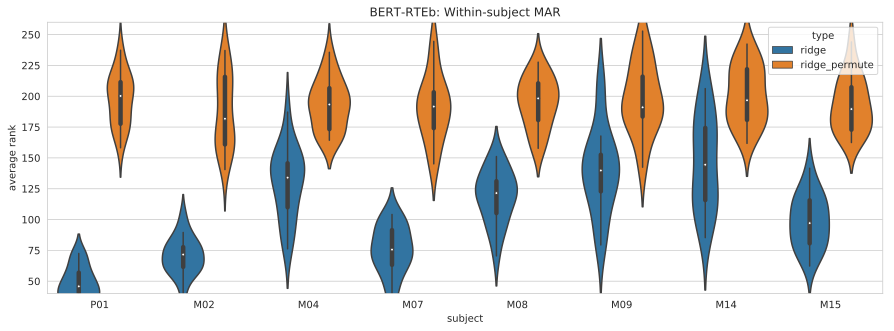

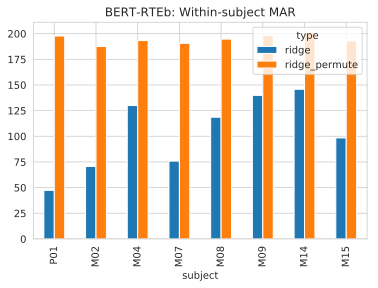

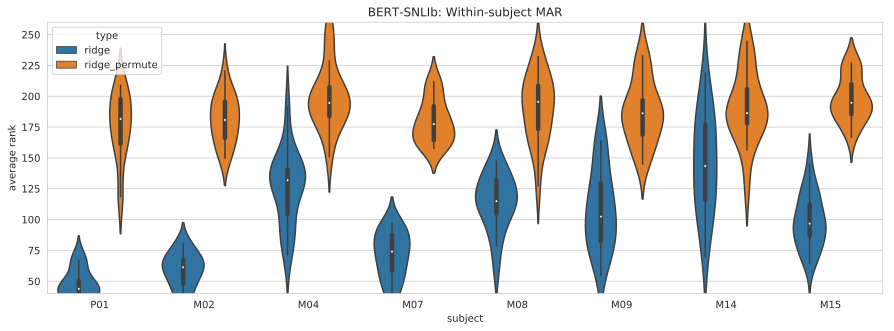

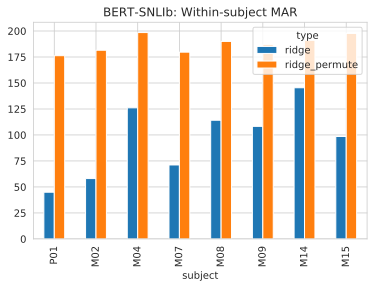

In [21]:
for model, path in models.items():
    try:
        stats[model] = analyze_encoding(model, "perf.384sentences.%s.csv" % path)
    except: pass

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [22]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "subject"]).reset_index()

In [23]:
f.head()

type,target,subject,ridge,ridge_permute
0,BERT,P01,48.703704,185.690476
1,BERT,M02,61.005291,181.613757
2,BERT,M04,129.359788,191.584656
3,BERT,M07,76.989418,187.447090
4,BERT,M08,118.492063,189.187831


In [24]:
# Load full model predictions.
model_preds = {model: pd.read_csv("perf.384sentences.%s.pred.csv" % model_path).sort_index() for model, model_path in models.items()}

In [31]:
from scipy.stats import wilcoxon
import itertools

wilcoxon_results = []
for (model1_name, model1), (model2_name, model2) in itertools.combinations(model_preds.items(), 2):
    if model2_name == model1_name + "b":
        w_stat, p_val = wilcoxon(model1["rank"], model2["rank"])
        wilcoxon_results.append((model1_name, model2_name, w_stat, p_val))
    
wilcoxon_results = pd.DataFrame(wilcoxon_results, columns=["model1", "model2", "w_stat", "p_val"]).set_index(["model1", "model2"])
# Bonferroni correction
correction = len(list(itertools.combinations(model_preds.items(), 2)))
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val"] < 0.01 / correction

In [32]:
wilcoxon_results.sort_values("p_val")

,,w_stat,p_val,significant_bonferroni
model1,model2,,,
BERT-QQP,BERT-QQPb,1320577.0,1.920565e-72,True
BERT-MNLI,BERT-MNLIb,1471781.0,3.792103e-50,True
BERT-RTE,BERT-RTEb,1541165.0,3.727183e-31,True
BERT-SNLI,BERT-SNLIb,1719986.0,1.690481e-18,True


---------

# Aggregate graphs

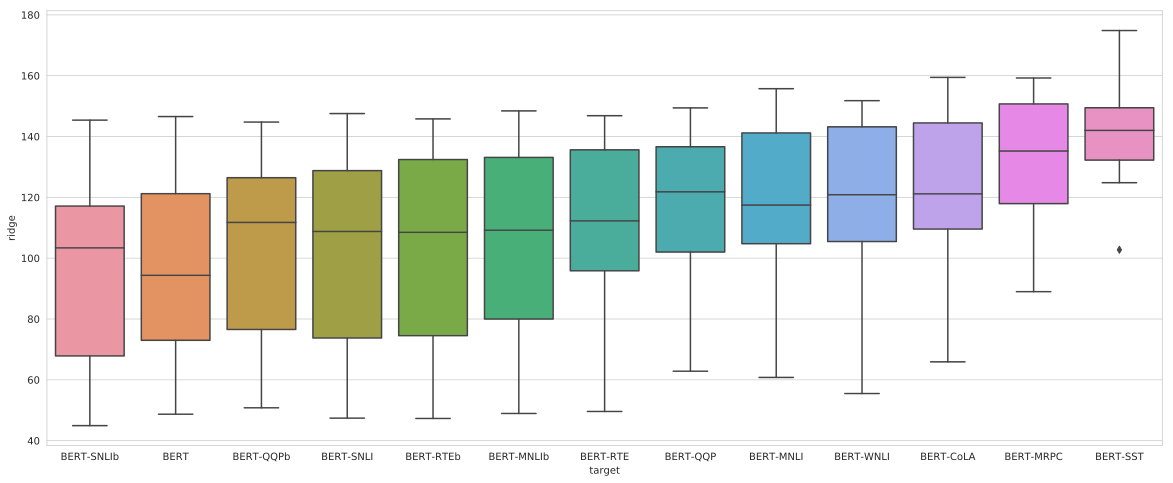

In [33]:
fig, ax = plt.subplots(figsize=(20, 8))

target_order = f.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f, ax=ax, order=target_order.index[target_order])

In [34]:
f.groupby("target").ridge.agg("mean")

target
BERT           96.226190
BERT-CoLA     121.166005
BERT-MNLI     117.606812
BERT-MNLIb    105.709325
BERT-MRPC     131.154431
BERT-QQP      116.450728
BERT-QQPb     102.254960
BERT-RTE      109.732804
BERT-RTEb     103.292328
BERT-SNLI     102.777447
BERT-SNLIb     95.816138
BERT-SST      140.350529
BERT-WNLI     117.740079
Name: ridge, dtype: float64

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  6.6  7.6  8.6  9.6 10.6 11.6  0. ]


Text(0.87, -0.07, '* = p<0.01 for Bonferroni-corrected Wilcoxon test')

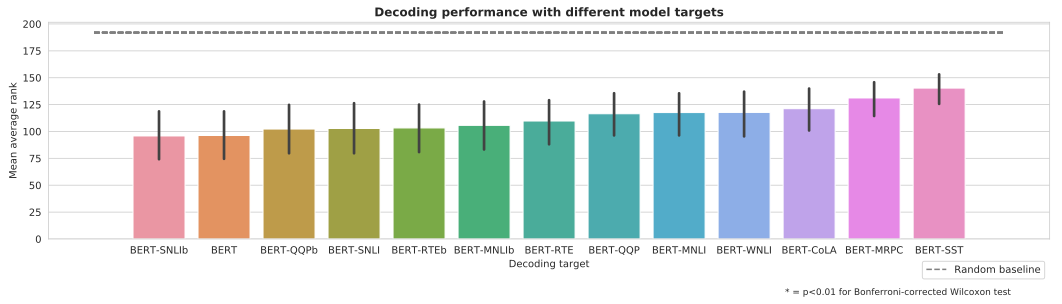

In [36]:
fig, ax = plt.subplots(figsize=(18,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance with different model targets", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.08))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
mean_results = f.groupby("target").ridge.agg("mean")
for (m1_pos, m1_label), (m2_pos, m2_label) in zip(xticks, xticks[1:]):
    m1_label = m1_label.get_text()
    m2_label = m2_label.get_text()
    try:
        significant = wilcoxon_results.loc[m1_label, m2_label].significant_bonferroni
    except:
        try:
            significant = wilcoxon_results.loc[m2_label, m1_label].significant_bonferroni
        except:
            continue
    
    if significant:
        y = max(mean_results[m1_label], mean_results[m2_label]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.07, "* = p<0.01 for Bonferroni-corrected Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Decoding performance between subjects')

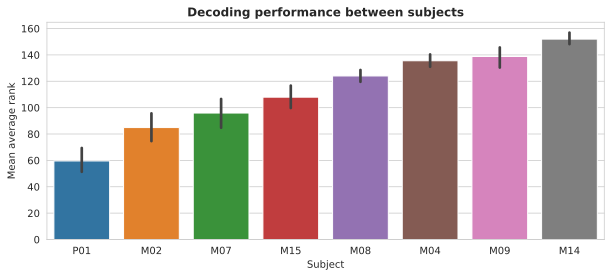

In [37]:
order = f.groupby("subject").ridge.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="subject", y="ridge", order=order.index[order], data=f, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")